In [1]:
# --- 1. SETUP & DOWNLOAD ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Directory setup
os.makedirs('data/raw', exist_ok=True)


ZIP_PATH = '/content/drive/MyDrive/LCL_2013_kWh.csv.zip'
CSV_PATH = 'data/raw/LCL_2013.csv'


# Unzip
if os.path.exists(ZIP_PATH) and not os.path.exists(CSV_PATH):
    print(f"Unzipping {ZIP_PATH}...")
    !unzip $ZIP_PATH -d data/raw/
    print("Unzip complete.")
elif os.path.exists(CSV_PATH):
    print("CSV file already exists.")
else:
    print(f"WARNING: Please upload {ZIP_PATH} to the Colab files sidebar under data/raw/")

Unzipping /content/drive/MyDrive/LCL_2013_kWh.csv.zip...
Archive:  /content/drive/MyDrive/LCL_2013_kWh.csv.zip
  inflating: data/raw/LCL_2013.csv   
Unzip complete.


In [2]:
# @title 1. Data Loading (Wide Format)
import pandas as pd
import numpy as np

class DataLoader:
    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        print(f"Loading data from {self.filepath}...")

        # Read CSV:
        # 1. Parse dates in the first column (index_col=0)
        # 2. handle 'NaN' strings as actual NaNs
        try:
            df = pd.read_csv(
                self.filepath,
                index_col=0,
                parse_dates=True
            )

            # The user noted: "Subsequent columns refer to measurements of single households"
            # We filter to ensure we only have numeric columns (Households)
            # Dropping any non-numeric artifacts if they exist
            df = df.select_dtypes(include=[np.number])

            print(f"Data Loaded Successfully.")
            print(f"Time Range: {df.index.min()} to {df.index.max()}")
            print(f"Households (Columns): {df.shape[1]}")
            print(f"Time Points (Rows): {df.shape[0]}")

            return df
        except Exception as e:
            print(f"Error loading data: {e}")
            return None


loader = DataLoader(CSV_PATH)
df_wide = loader.load_data()

Loading data from data/raw/LCL_2013.csv...
Data Loaded Successfully.
Time Range: 2013-01-01 00:30:00 to 2014-01-01 00:00:00
Households (Columns): 4443
Time Points (Rows): 17520


In [3]:
# @title 2. Feature Engineering
class FeatureEngineer:
    def __init__(self, df_wide):
        self.df = df_wide

    def create_household_profiles(self):
        print("Engineering household profiles...")

        # 1. General Statistics (Per Household)
        # Transpose (.T) is not needed yet, we just aggregate the columns
        profiles = pd.DataFrame()
        profiles['mean_usage'] = self.df.mean()
        profiles['std_dev'] = self.df.std()
        profiles['max_usage'] = self.df.max()
        profiles['total_usage'] = self.df.sum()

        # 2. Time of Day Analysis
        # Create a helper series for hours based on the index
        hours = self.df.index.hour

        # Define time bins
        # Night: 0-6, Morning: 6-12, Afternoon: 12-18, Evening: 18-24
        # We use boolean indexing on the rows (Time) to filter, then take the mean of columns (Households)

        print("Calculating Time-of-Day averages...")
        profiles['mean_Night'] = self.df[hours < 6].mean()
        profiles['mean_Morning'] = self.df[(hours >= 6) & (hours < 12)].mean()
        profiles['mean_Afternoon'] = self.df[(hours >= 12) & (hours < 18)].mean()
        profiles['mean_Evening'] = self.df[hours >= 18].mean()

        # Fill any NaNs (e.g., if a household had NO readings during 'Night') with 0
        profiles.fillna(0, inplace=True)

        print(f"Profiles created for {len(profiles)} households.")
        return profiles

# Execution
engineer = FeatureEngineer(df_wide)
household_profiles = engineer.create_household_profiles()

# Show first 5 households (MAC ids)
display(household_profiles.head())

Engineering household profiles...
Calculating Time-of-Day averages...
Profiles created for 4443 households.


,mean_usage,std_dev,max_usage,total_usage,mean_Night,mean_Morning,mean_Afternoon,mean_Evening
MAC000002,0.240578,0.239675,2.994,4214.925000,0.159819,0.198443,0.234297,0.369752
MAC000003,0.400065,0.639823,3.757,7008.341003,0.976693,0.301093,0.165127,0.157424
MAC000004,0.035290,0.071773,0.690,618.246000,0.034573,0.035409,0.035578,0.035601
MAC000006,0.060152,0.054593,0.774,1053.865000,0.031242,0.074792,0.056701,0.077873
MAC000007,0.195187,0.233439,3.784,3419.091999,0.072480,0.221425,0.220357,0.266504


Silhouette Score: 0.4010


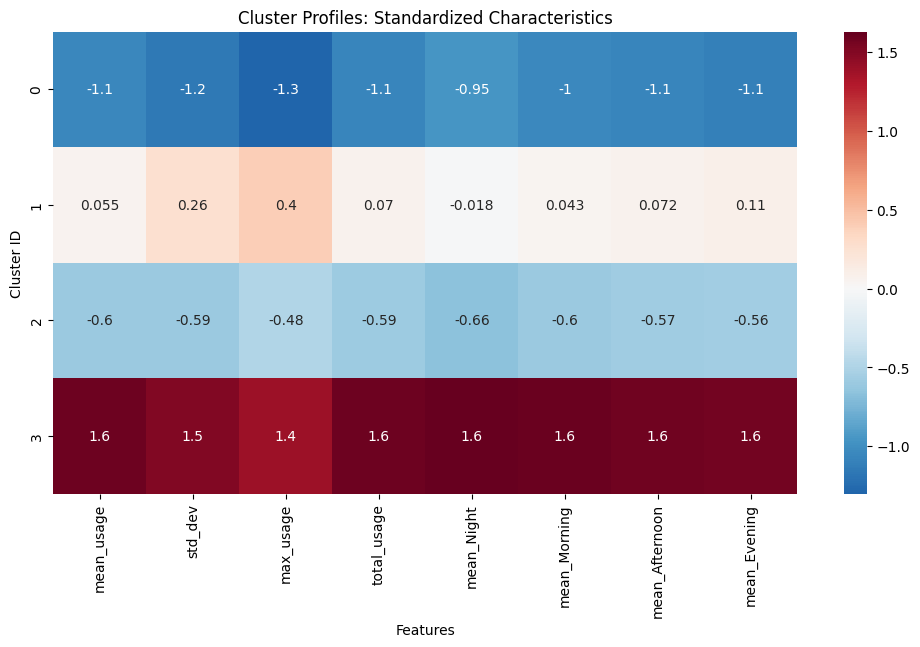


Cluster Interpretation:


,mean_usage,std_dev,max_usage,total_usage,mean_Night,mean_Morning,mean_Afternoon,mean_Evening
cluster,,,,,,,,
0,0.111752,0.116171,1.490009,1871.234106,0.066934,0.107121,0.121478,0.151478
1,0.443979,0.443756,3.781279,7402.324203,0.318454,0.421334,0.468765,0.567377
2,0.248594,0.247073,2.587027,4190.181871,0.144546,0.233919,0.275218,0.340705
3,0.905556,0.728347,5.095506,14779.810303,0.762901,0.873019,0.922770,1.063598


In [4]:
# @title 3. Clustering & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

class ClusteringAnalysis:
    def __init__(self, profiles, n_clusters=4):
        self.profiles = profiles
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.scaler = StandardScaler()
        self.results = None

    def run(self):
        # Scale data
        scaled_data = self.scaler.fit_transform(self.profiles)

        # Train
        labels = self.model.fit_predict(scaled_data)

        # Attach results
        self.results = self.profiles.copy()
        self.results['cluster'] = labels

        # Metric [cite: 31]
        score = silhouette_score(scaled_data, labels)
        print(f"Silhouette Score: {score:.4f}")
        return self.results

    def plot_heatmap(self):
        """Generates the profile heatmap required for the results chapter [cite: 216]"""
        cluster_means = self.results.groupby('cluster').mean()

        # Normalize for visualization (Z-score)
        scaler = StandardScaler()
        scaled_means = pd.DataFrame(
            scaler.fit_transform(cluster_means),
            index=cluster_means.index,
            columns=cluster_means.columns
        )

        plt.figure(figsize=(12, 6))
        sns.heatmap(scaled_means, annot=True, cmap="RdBu_r", center=0)
        plt.title('Cluster Profiles: Standardized Characteristics')
        plt.ylabel('Cluster ID')
        plt.xlabel('Features')
        plt.show()

# Execution
cluster_engine = ClusteringAnalysis(household_profiles, n_clusters=4)
results = cluster_engine.run()
cluster_engine.plot_heatmap()

# Text Summary
print("\nCluster Interpretation:")
display(results.groupby('cluster').mean())

In [5]:
# @title 1. Data Preparation: Aggregate by Cluster
class ClusterDataPrep:
    def __init__(self, time_series_df, cluster_assignments):
        self.raw_df = time_series_df
        self.clusters = cluster_assignments['cluster']

    def create_cluster_series(self):
        print("Aggregating data by cluster...")

        # Transpose raw_df so Households are rows, join with clusters
        # (This is memory intensive, so we use a smarter loop approach)

        cluster_series = pd.DataFrame(index=self.raw_df.index)

        unique_clusters = sorted(self.clusters.unique())
        for c in unique_clusters:
            # Get all households belonging to cluster c
            households_in_c = self.clusters[self.clusters == c].index

            # Filter columns in the big dataframe that match these households
            # Intersection is needed because some filtered households might not be in the raw df
            valid_cols = self.raw_df.columns.intersection(households_in_c)

            if len(valid_cols) > 0:
                # Calculate mean consumption for this cluster at every timestamp
                cluster_series[f'Cluster_{c}'] = self.raw_df[valid_cols].mean(axis=1)

        print(f"Aggregated Series Created. Shape: {cluster_series.shape}")
        return cluster_series

# Execution
prep = ClusterDataPrep(df_wide, results)
df_clusters = prep.create_cluster_series()
df_clusters.head()

Aggregating data by cluster...
Aggregated Series Created. Shape: (17520, 4)


,Cluster_0,Cluster_1,Cluster_2,Cluster_3
DateTime,,,,
2013-01-01 00:30:00,0.113180,0.572068,0.267913,1.074933
2013-01-01 01:00:00,0.100865,0.515061,0.247442,1.029596
2013-01-01 01:30:00,0.093756,0.477227,0.221634,0.986034
2013-01-01 02:00:00,0.084412,0.435352,0.206319,0.901697
2013-01-01 02:30:00,0.078228,0.401176,0.181421,0.849022


In [6]:
# @title 2. Prediction Module (Random Forest)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

class ClusterPredictor:
    def __init__(self, data):
        self.data = data.copy()
        self.models = {}
        self.metrics = {}

    def create_features(self, df, target_col):
        """
        Creates Time features + Lag features for supervised learning
        """
        df = df[[target_col]].copy()
        df.rename(columns={target_col: 'target'}, inplace=True)

        # 1. Time Features
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['month'] = df.index.month
        df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

        # 2. Lag Features (Windowing)
        # Lag 1: Previous half-hour
        df['lag_1'] = df['target'].shift(1)
        # Lag 2: Previous hour
        df['lag_2'] = df['target'].shift(2)
        # Lag 48: Same time yesterday (48 half-hours in a day)
        df['lag_48'] = df['target'].shift(48)

        # Drop NaNs created by lagging
        df.dropna(inplace=True)
        return df

    def train_and_evaluate(self):
        print("Training models for each cluster...")

        # Iterate through each cluster column (Cluster_0, Cluster_1...)
        for col in self.data.columns:
            print(f"Training for {col}...")

            # Feature Engineering
            df_features = self.create_features(self.data, col)

            # Split X/y
            X = df_features.drop(columns=['target'])
            y = df_features['target']

            # Time-based Train/Test Split (80% Train, 20% Test)
            # We don't use random split because time series order matters
            split_idx = int(len(X) * 0.8)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

            # Train Model (Random Forest)
            model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)

            # Predict
            preds = model.predict(X_test)

            # Evaluate
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            mae = mean_absolute_error(y_test, preds)

            self.models[col] = model
            self.metrics[col] = {'RMSE': rmse, 'MAE': mae}

            # Store predictions for plotting later
            self.data.loc[y_test.index, f'{col}_Pred'] = preds

        return pd.DataFrame(self.metrics).T

# Execution
predictor = ClusterPredictor(df_clusters)
metrics = predictor.train_and_evaluate()

print("\nPrediction Performance (Validation with Historical Data):")
display(metrics)

Training models for each cluster...
Training for Cluster_0...
Training for Cluster_1...
Training for Cluster_2...
Training for Cluster_3...

Prediction Performance (Validation with Historical Data):


,RMSE,MAE
Cluster_0,0.003977,0.002887
Cluster_1,0.021780,0.016746
Cluster_2,0.009840,0.007122
Cluster_3,0.053372,0.041384


In [7]:
# @title 3. Anomaly Detection Pipeline
from sklearn.ensemble import IsolationForest

class AnomalyDetector:
    def __init__(self, raw_data, contamination=0.01):
        """
        raw_data: Series of energy consumption for ONE household
        contamination: Expected % of anomalies (0.01 = top 1% outliers)
        """
        self.data = raw_data.to_frame(name='usage')
        self.model = IsolationForest(contamination=contamination, random_state=42)

    def detect(self):
        # Feature Engineering for Anomaly Detection (similar to prediction)
        # Isolation Forest works better with context (hour, day)
        self.data['hour'] = self.data.index.hour
        self.data['dayofweek'] = self.data.index.dayofweek

        # Fit model
        self.data['anomaly_score'] = self.model.fit_predict(self.data[['usage', 'hour', 'dayofweek']])

        # Isolation Forest returns -1 for anomalies, 1 for normal
        # Map -1 to True (Anomaly), 1 to False (Normal)
        self.data['is_anomaly'] = self.data['anomaly_score'] == -1

        num_anomalies = self.data['is_anomaly'].sum()
        print(f"Detection Complete. Found {num_anomalies} anomalies out of {len(self.data)} points.")

        return self.data

# Execution: Pick a random heavy user from Cluster 3 (if available)
try:
    # Find a user in Cluster 3 (Heavy Users)
    target_cluster = 3
    user_id = results[results['cluster'] == target_cluster].index[0]
    print(f"Running Anomaly Detection for Heavy User: {user_id}")

    # Extract that user's data
    user_series = df_wide[user_id].dropna()

    # Run Detection
    detector = AnomalyDetector(user_series, contamination=0.02)
    anomaly_results = detector.detect()

except IndexError:
    print("Cluster 3 might be empty. Trying Cluster 0...")
    user_id = results[results['cluster'] == 0].index[0]
    user_series = df_wide[user_id].dropna()
    detector = AnomalyDetector(user_series)
    anomaly_results = detector.detect()

Running Anomaly Detection for Heavy User: MAC000049
Detection Complete. Found 351 anomalies out of 17520 points.


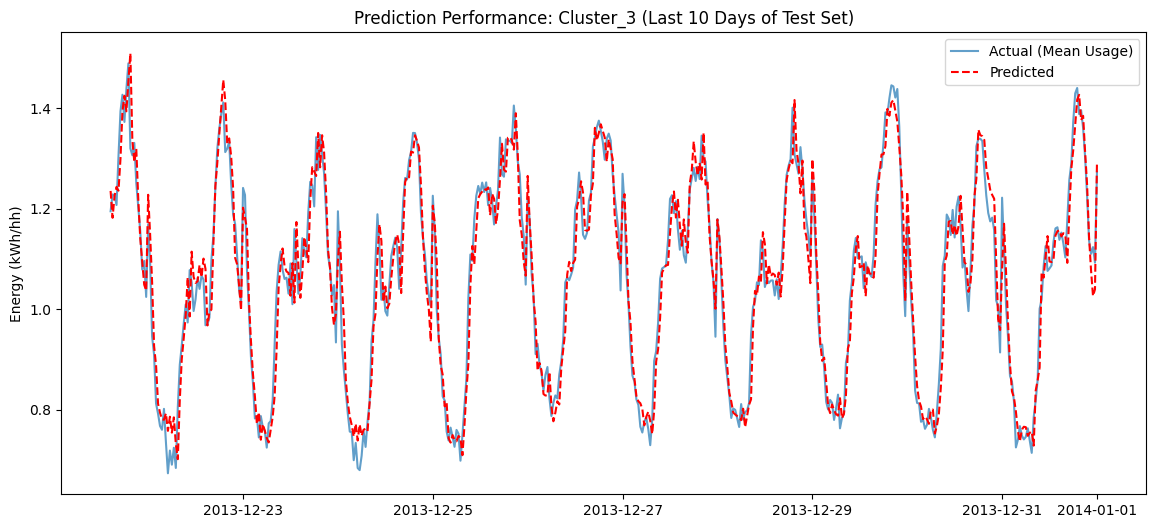

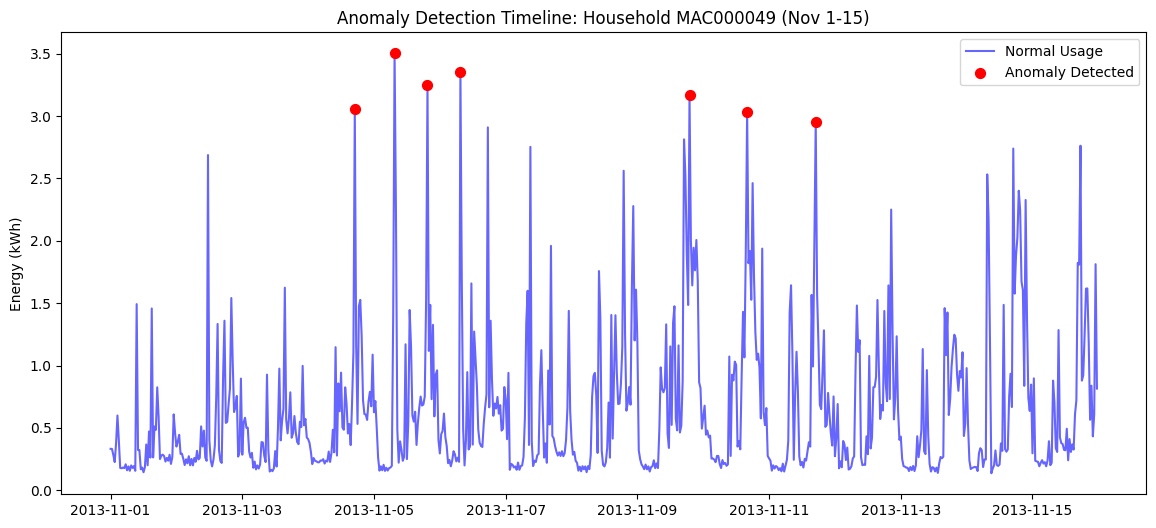

In [8]:
# @title 4. Visualization of Results
class ResultsVisualizer:
    def plot_prediction(self, full_data, cluster_name):
        """Plots Actual vs Predicted for the Test period"""
        plt.figure(figsize=(14, 6))

        # Slice the last 500 points (approx 10 days) for clarity
        plot_data = full_data.iloc[-500:]

        plt.plot(plot_data.index, plot_data[cluster_name], label='Actual (Mean Usage)', alpha=0.7)
        plt.plot(plot_data.index, plot_data[f'{cluster_name}_Pred'], label='Predicted', linestyle='--', color='red')

        plt.title(f'Prediction Performance: {cluster_name} (Last 10 Days of Test Set)')
        plt.ylabel('Energy (kWh/hh)')
        plt.legend()
        plt.show()

    def plot_anomalies(self, anomaly_df, user_id):
        """Plots time series with red dots for anomalies"""
        # Plot a subset (e.g., 2 weeks in Winter) where anomalies might occur
        subset = anomaly_df['2013-11-01':'2013-11-15']

        plt.figure(figsize=(14, 6))
        plt.plot(subset.index, subset['usage'], label='Normal Usage', color='blue', alpha=0.6)

        # Overlay anomalies
        anomalies = subset[subset['is_anomaly']]
        plt.scatter(anomalies.index, anomalies['usage'], color='red', label='Anomaly Detected', s=50, zorder=5)

        plt.title(f'Anomaly Detection Timeline: Household {user_id} (Nov 1-15)')
        plt.ylabel('Energy (kWh)')
        plt.legend()
        plt.show()

# Visualize
viz = ResultsVisualizer()

# 1. Prediction Plot (for Cluster 3 - Heavy Users)
# Check if Cluster_3 exists in columns, otherwise plot Cluster_0
plot_col = 'Cluster_3' if 'Cluster_3' in predictor.data.columns else 'Cluster_0'
viz.plot_prediction(predictor.data, plot_col)

# 2. Anomaly Plot
viz.plot_anomalies(anomaly_results, user_id)

In [9]:
# --- EXPORT DATA FOR DASHBOARD ---
import os

# 1. Save Clustered Data (The household profiles + cluster labels)
# Assuming 'results' is the dataframe from Step 4 of the previous notebook
results.to_csv('dashboard_data_clusters.csv')

# 2. Save Prediction Data (Actual vs Predicted for Clusters)
# Assuming 'predictor.data' contains the columns 'Cluster_0', 'Cluster_0_Pred', etc.
predictor.data.to_csv('dashboard_data_predictions.csv')

# 3. Save Anomaly Data (The example user we found)
# Assuming 'anomaly_results' is the dataframe from Step 3
anomaly_results.to_csv('dashboard_data_anomalies.csv')

print("Files saved! Please download these 3 CSV files to your local machine.")

Files saved! Please download these 3 CSV files to your local machine.


--- RUNNING CLUSTERING COMPARISON ---


,Algorithm,Silhouette Score (Higher is Better),Davies-Bouldin (Lower is Better),Clusters Found
0,K-Means,0.401011,0.986535,4
1,Hierarchical (Ward),0.365848,1.203349,4
2,DBSCAN,0.778669,0.743733,1



--- RUNNING PREDICTION COMPARISON ---


,Cluster,Random Forest RMSE,Linear Regression RMSE,Improvement (%)
0,Cluster_0,0.000017,0.000043,61.185898
1,Cluster_1,0.000487,0.000942,48.339905
2,Cluster_2,0.000099,0.000268,62.955790
3,Cluster_3,0.002812,0.003521,20.147689


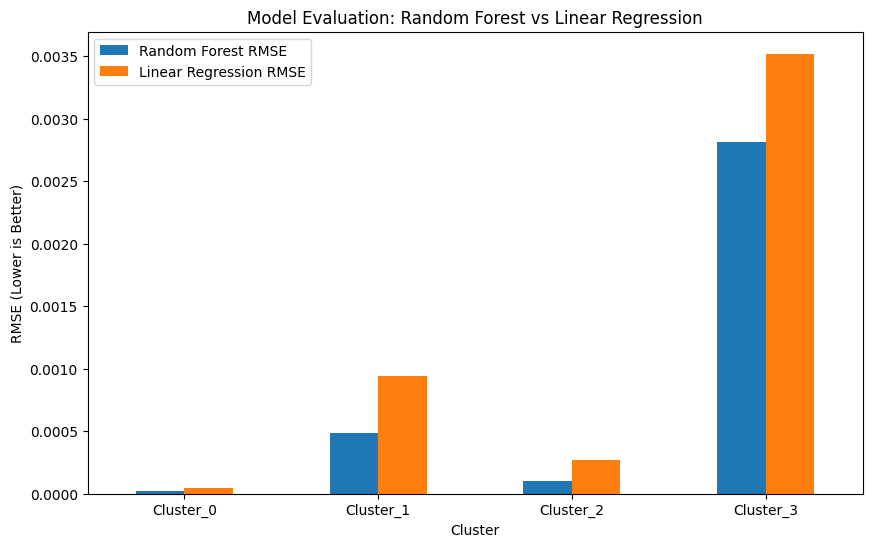

In [11]:
# @title 🎓 Comparative Analysis (Dissertation Benchmarking)
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score, mean_squared_error, davies_bouldin_score

# --- PART A: CLUSTERING COMPARISON ---
print("--- RUNNING CLUSTERING COMPARISON ---")

# Data Prep
X_cluster = StandardScaler().fit_transform(household_profiles)

# 1. K-Means (Our Baseline)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_km = kmeans.fit_predict(X_cluster)

# 2. Hierarchical (Agglomerative)
agglo = AgglomerativeClustering(n_clusters=4)
labels_agg = agglo.fit_predict(X_cluster)

# 3. DBSCAN (Density Based)
# eps=0.5 is standard for Z-scored data, min_samples=5 is default
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_db = dbscan.fit_predict(X_cluster)

# Store Metrics
cluster_metrics = {
    'Algorithm': ['K-Means', 'Hierarchical (Ward)', 'DBSCAN'],
    'Silhouette Score (Higher is Better)': [
        silhouette_score(X_cluster, labels_km),
        silhouette_score(X_cluster, labels_agg),
        silhouette_score(X_cluster, labels_db) if len(set(labels_db)) > 1 else 0
    ],
    'Davies-Bouldin (Lower is Better)': [
        davies_bouldin_score(X_cluster, labels_km),
        davies_bouldin_score(X_cluster, labels_agg),
        davies_bouldin_score(X_cluster, labels_db) if len(set(labels_db)) > 1 else 0
    ],
    'Clusters Found': [
        len(set(labels_km)),
        len(set(labels_agg)),
        len(set(labels_db)) - (1 if -1 in labels_db else 0) # Exclude noise
    ]
}

df_cluster_compare = pd.DataFrame(cluster_metrics)
display(df_cluster_compare)


# --- PART B: PREDICTION COMPARISON ---
print("\n--- RUNNING PREDICTION COMPARISON ---")

prediction_metrics = []

# Loop through each cluster profile
for col in df_clusters.columns:
    if 'Pred' in col: continue # Skip prediction columns

    # 1. Feature Engineering (Reuse logic)
    # We recreate the features for this specific cluster column
    temp_df = df_clusters[[col]].copy()
    temp_df.columns = ['target']
    temp_df['hour'] = temp_df.index.hour
    temp_df['dayofweek'] = temp_df.index.dayofweek
    temp_df['lag_1'] = temp_df['target'].shift(1)
    temp_df['lag_48'] = temp_df['target'].shift(48)
    temp_df.dropna(inplace=True)

    X = temp_df.drop(columns=['target'])
    y = temp_df['target']

    # Split
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # 2. Model A: Random Forest (Our Choice)
    rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    rmse_rf = mean_squared_error(y_test, pred_rf)

    # 3. Model B: Linear Regression (Benchmark)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    rmse_lr = mean_squared_error(y_test, pred_lr)

    prediction_metrics.append({
        'Cluster': col,
        'Random Forest RMSE': rmse_rf,
        'Linear Regression RMSE': rmse_lr,
        'Improvement (%)': ((rmse_lr - rmse_rf) / rmse_lr) * 100
    })

df_pred_compare = pd.DataFrame(prediction_metrics)
display(df_pred_compare)

# --- VISUALIZATION FOR DISSERTATION ---
# Plot Prediction Comparison
fig, ax = plt.subplots(figsize=(10, 6))
df_pred_compare.plot(x='Cluster', y=['Random Forest RMSE', 'Linear Regression RMSE'], kind='bar', ax=ax)
plt.title('Model Evaluation: Random Forest vs Linear Regression')
plt.ylabel('RMSE (Lower is Better)')
plt.xticks(rotation=0)
plt.show()